In [1]:
!pip install -q streamlit
# !pip install -q transformers==4.36.0
# !pip install -q bitsandbytes==0.41.3 accelerate==0.26.0
# !pip install -q -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 637.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
# import streamlit as st
import numpy as np
from PIL import Image
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)

model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    load_in_4bit=True
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [ ]:
%%writefile recycling_app.py
import streamlit as st
from PIL import Image
import numpy as np
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
import pandas as pd

model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)

llava_model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    load_in_4bit=True
)

if 'recent_output' not in st.session_state:
    st.session_state['recent_output'] = 0

def retrive_instruct(class_choice, location_name):
  recycling_instruction_dataset = [
    {'location_id':1,
    'location':"Cook County, IL",
     'instructions': [
         {
         "instruc_id":0,
         "items": "metal",
         "instructions": "Metal objects that are able to be recycled includes steel and aluminum containers and foil."
        },
         {"instruc_id":1,
         "items": "paper",
         "instructions": "paper that can be recycled includes cardboard (flattened), office paper, newspaper, and magazines"
          },
         {
          "instruc_id":2,
         "items": "glass",
         "instructions": "glass items that can be recycled includes glass bottles and jars only"
         },
         {
          "instruc_id":3,
         "items": "plastic",
         "instructions": """Plastic items that can be recycled includes plastic bottles, tubs, jugs, and jars only.
          Always replace your cap onto the empty and clean plastic bottle it came from.
          Then, place into your recycling bin to ensure both plastic components are successfully processed at your local recycling facility."""
         },
         {
          "instruc_id":4,
         "items": "coffee cups",
         "instructions": """Your cup of joe is a recycling no. Lids, straws, and hot beverage cups should be kept out of your curbside recycling bin.
          Despite the paper composition of hot beverage cups, they contain a lining that degrades the overall quality of the recycling batch and should not be recycled in your bin.
          For iced coffee, some uncertainty remains about whether the plastic cup is recyclable. Please check with your local authority to determine whether plastic coffee cups can go in your bin.
          To reduce waste and save resources, use a reusable coffee cup and straw! Some coffee establishments even offer discounts when you bring your own cup/mug."""
         },
         {
          "instruc_id":5,
         "items": "other",
         "instructions": "This item is not included in the this of acceptable recyclables, please dispose of it in the garbage."
         }
         ]
     },
    {
      'location_id':2,
      'location':"Palm Desert, CA",
      'instructions': [
         {
         "instruc_id":0,
         "items": "metal and glass",
         "instructions": """The following metal and glass items can be recycled:
         -Aluminum, steel, and tin cans,
         -Clean aluminum foil,
        - Glass bottles and jars (remove lids)"""
        },
         {"instruc_id":1,
         "items": "paper",
         "instructions": """
         The following paper items can be recycled:
        - White and colored paper,
        - Phone books,
        - Magazines,
        - Junk Mail,
        - Envelopes,
        - File folders,
        - Cardboard (flattened),
        - Cartons (milk, juice, & broth),
        - Books (remove hard covers or binding),
        - Cardboard boxes, e.g. cereal, etc.
         """
          },
         {
          "instruc_id":2,
         "items": "plastic",
         "instructions": """Plastic items that can be recycled includes:
          - Styrofoam packing blocks
          - Plastic medicine bottles (empty)
          - Plastic bottles numbered 1-7 (remove plastic film or wrap)"""
         },
         {
          "instruc_id":3,
         "items": "other naps",
         "instructions": "This item is not included in the this of acceptable recyclables, please dispose of it in the garbage."
         }
         ]
    }
  ]

  locations_list = [x['location_id'] for x in recycling_instruction_dataset]

  locations_dict = {"Palm Desert":2, "Cook County":1}
  loc_num = locations_dict[location_name]

  loc_idx = locations_list.index(loc_num)

  loc_dict = recycling_instruction_dataset[loc_idx]

  instructions_dict_list = loc_dict['instructions']


  classes_col = np.repeat(np.arange(1, 8), 2)
  loc_name = np.tile(['Cook County, IL', 'Palm Desert, CA'], 7)
  loc_idx = np.tile([1, 2], 7)
  mapping_to_instruc = [0, 0, 0, 0, 4, 3, 1, 1, 2, 0, 3, 2, 5, 3]

  instruc_mapping_df = pd.DataFrame({'pred_class': classes_col, 'location': loc_name, 'location_id': loc_idx, 'instruction_id': mapping_to_instruc})
  relevant_sec_id = instruc_mapping_df[(instruc_mapping_df['pred_class']==class_choice) & (instruc_mapping_df['location_id']==loc_num)]['instruction_id'].values[0]
  instruc_id_list = [x['instruc_id'] for x in instructions_dict_list]

  instruc_idx = instruc_id_list.index(relevant_sec_id)

  retrieve_instruc = instructions_dict_list[instruc_idx]['instructions']

  return retrieve_instruc

def knn_rag(stage_1_output, location):
  embeddings_cluster_dict = {"aluminum food can":1,
              "tin can":1,
              "steel can":1,
              "canned food container":1,
              "canned food can":1,
              "soda can":2,
              "beverage can":2,
              "soft drink can":2,
              "pepsi can":2,
              "coca cola can":2,
              "paper cup":3,
              "hot beverage cup":3,
              "coffee cup":3,
              "lined paper cup":3,
              "disposable coffee cup":3,
              "white paper cup":3,
              "cardboard":4,
             "cardboard box":4,
              "box":4,
              "packing box":4,
              "cereal box":4,
              "glass bottle":5,
              "glass drink container":5,
              "alcohol bottle":5,
              "beer bottle":5,
              "water bottle":6,
              "disposable water bottle":6,
              "plastic bottle":6,
              "plastic soda bottle":6}

  reference_words_list = list(embeddings_cluster_dict.keys())
  encoder_model = SentenceTransformer('sentence-transformers/LaBSE')
  reference_embeddings = encoder_model.encode(reference_words_list)

  knn_model = NearestNeighbors(n_neighbors=1)
  knn_model.fit(reference_embeddings)

  query_llava = encoder_model.encode(stage_1_output)

  dists, idxs = knn_model.kneighbors([query_llava])

  neighbor = reference_words_list[idxs[0][0]]

  distance = dists[0]

  if distance <0.9:
    class_num = embeddings_cluster_dict[neighbor]
  else:
    class_num = 7

  instruction = retrive_instruct(class_num, location)

  return class_num, instruction


def run_model(input_img, loc):
  # model_id = "llava-hf/llava-1.5-7b-hf"

  # processor = AutoProcessor.from_pretrained(model_id)

  # model = LlavaForConditionalGeneration.from_pretrained(
  #     model_id,
  #     torch_dtype=torch.float16,
  #     low_cpu_mem_usage=True,
  #     load_in_4bit=True
  # )
  prompt = f"USER: <image>\nWhat is this waste item and what material is the waste item made from, output a one phrase answer, don't consider the brand\nASSISTANT:"

  inputs = processor(prompt, input_img, return_tensors='pt').to(0, torch.float16)

  output = llava_model.generate(**inputs, max_new_tokens=25, do_sample=False, temperature = 0)

  output_str = processor.decode(output[0][2:], skip_special_tokens=True)

  output_idx = output_str.index("ASSISTANT") + 11
  stage_1 = output_str[output_idx:]

  class_num, instruction = knn_rag(stage_1, loc)

  prompt = f"USER: <image>\n Given these instructions: {instruction}. Is {stage_1} in the image recyclable Choose yes or no\nASSISTANT:"

  inputs = processor(prompt, input_img, return_tensors='pt').to(0, torch.float16)

  output = llava_model.generate(**inputs, max_new_tokens=5, do_sample=False, temperature = 0)

  output_str = processor.decode(output[0][2:], skip_special_tokens=True)

  output_idx = output_str.index("ASSISTANT") + 11
  stage_2 = output_str[output_idx:]

  prompt = f"USER: <image>\n Given these instructions: {instruction}. Is this item able to be reyclced: {stage_2}. Please give instructions on how to recycle item in image\nASSISTANT:"

  inputs = processor(prompt, input_img, return_tensors='pt').to(0, torch.float16)

  output = llava_model.generate(**inputs, max_new_tokens=50, do_sample=False, temperature = 0)

  output_str = processor.decode(output[0][2:], skip_special_tokens=True)

  output_idx = output_str.index("ASSISTANT") + 11
  stage_3 = output_str[output_idx:]

  return stage_3

# def load_model():
#   model_id = "llava-hf/llava-1.5-7b-hf"

#   processor = AutoProcessor.from_pretrained(model_id)

#   model = LlavaForConditionalGeneration.from_pretrained(
#       model_id,
#       torch_dtype=torch.float16,
#       low_cpu_mem_usage=True,
#       load_in_4bit=True
#   )

#   return model, processor

def get_image():
  # example input image
  image_arr = np.load("/content/drive/My Drive/capstone_project/image_data/data_x.npy", allow_pickle = True)
  test_im = Image.fromarray(np.uint8(image_arr[20]))

  # output = run_model(test_im)
  return test_im

def home():
  st.title("Home")
  st.write("This is the home page")

def model():
  st.title("Run Model")
  st.write("This is where is model goes")
  loc_option = st.selectbox(
    "What is your location?",
    ("Palm Desert", "Cook County"),
)
  # image_to_display = get_image()
  # model, processor = load_model()
  st.write("Take a picture of something that you want to throw away and input to learn how to recycle")
  img_exists = False
  image = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])
  if image is not None:
    image_input = Image.open(image)
    img_exists = True
    st.image(image)
  # st.button("Create Instructions")
    if st.button("Create Instructions"):
      model_output = run_model(image_input, loc_option)
      st.write("The instructions for how to recycle:")
      st.write(model_output)

  else:
    st.write("Please upload an image")

def results():
  st.title("Find your recycling instructions here!")

  if st.session_state['recent_output'] != 0:
    st.write("Here are your recycling instructions: \n")
    st.write(st.session_state['recent_output'])

  else:
    st.write("Please run the model to get your instructions")

def about():
  st.title("About")
  st.write("This is the about page")

pg = st.navigation([st.Page(home), st.Page(model), st.Page(results), st.Page(about)])
pg.run()
# def main():
#   menu = ["Home", "Model", "About"]
#   choice = st.sidebar.selectbox("Menu", menu)

#   if choice == "Home":
#     home()
#   elif choice == "Model":
#     model()
#   elif choice == "About":
#     about()

# if __name__ == "__main__":
#   main()

Overwriting recycling_app.py


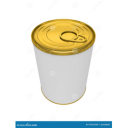

In [ ]:
image_arr = np.load("/content/drive/My Drive/capstone_project/image_data/data_x.npy", allow_pickle = True)
test_im = Image.fromarray(np.uint8(image_arr[20]))
test_im

### Launch Streamlit

In [ ]:
!npm install localtunnel


up to date, audited 23 packages in 698ms

3 packages are looking for funding
  run `npm fund` for details

2 moderate severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [ ]:
!streamlit run recycling_app.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

34.16.167.232
your url is: https://afraid-hoops-ring.loca.lt


In [ ]:
!

34.169.128.125
your url is: https://proud-moles-love.loca.lt


### test for only UI

In [7]:
%%writefile recycling_app_test_ui.py
import streamlit as st
from PIL import Image
import numpy as np
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
import pandas as pd

def get_image():
  # example input image
  image_arr = np.load("/content/drive/My Drive/capstone_project/image_data/data_x.npy", allow_pickle = True)
  test_im = Image.fromarray(np.uint8(image_arr[20]))

  # output = run_model(test_im)
  return test_im

def home():
  st.title("Home")
  st.write("This is the home page")

def recycling_hub():
  st.title("Recycle Right: Smart Recycling Model")
  st.write("Learn how to recycle with the recycling assistant Jane")
  recycling_image_monkey = Image.open("/content/drive/My Drive/capstone_project/monkey.png")
  st.image(recycling_image_monkey)
  loc_option = st.selectbox(
    "What is your location?",
    ("Palm Desert", "Cook County"),
)
  # image_to_display = get_image()
  # model, processor = load_model()
  st.write("Take a picture of something that you want to throw away and input to learn how to recycle")
  img_exists = False
  image = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])
  if image is not None:
    image_input = Image.open(image)
    img_exists = True
    st.image(image)
  # st.button("Create Instructions")
    # if st.button("Create Instructions"):
    #   model_output = run_model(image_input, loc_option)
    st.write("The instructions for how to recycle:")
    #   st.write(model_output)
    st.write("Aluminum cans can be recycled in Palm Desert, CA. Please dispose of it in the nearest recycling")

  else:
    st.write("Please upload an image")

# def results():
#   st.title("Find your recycling instructions here!")

#   if st.session_state['recent_output'] != 0:
#     st.write("Here are your recycling instructions: \n")
#     st.write(st.session_state['recent_output'])

#   else:
#     st.write("Please run the model to get your instructions")

def about():
  st.title("About")
  st.write("This is the about page")

pg = st.navigation([st.Page(home), st.Page(recycling_hub), st.Page(about)])
pg.run()

Overwriting recycling_app_test_ui.py


In [4]:
!npm install localtunnel


added 22 packages, and audited 23 packages in 2s

3 packages are looking for funding
  run `npm fund` for details

2 moderate severity vulnerabilities

To address all issues, run:
  npm audit fix

Run `npm audit` for details.


In [8]:
!streamlit run recycling_app_test_ui.py &>/content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

35.185.107.78
your url is: https://tasty-pugs-occur.loca.lt


## test outside of streamlit

In [ ]:
import streamlit as st
from PIL import Image
import numpy as np
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
import pandas as pd



def retrive_instruct(class_choice, location_name):
  recycling_instruction_dataset = [
    {'location_id':1,
    'location':"Cook County, IL",
     'instructions': [
         {
         "instruc_id":0,
         "items": "metal",
         "instructions": "Metal objects that are able to be recycled includes steel and aluminum containers and foil."
        },
         {"instruc_id":1,
         "items": "paper",
         "instructions": "paper that can be recycled includes cardboard (flattened), office paper, newspaper, and magazines"
          },
         {
          "instruc_id":2,
         "items": "glass",
         "instructions": "glass items that can be recycled includes glass bottles and jars only"
         },
         {
          "instruc_id":3,
         "items": "plastic",
         "instructions": """Plastic items that can be recycled includes plastic bottles, tubs, jugs, and jars only.
          Always replace your cap onto the empty and clean plastic bottle it came from.
          Then, place into your recycling bin to ensure both plastic components are successfully processed at your local recycling facility."""
         },
         {
          "instruc_id":4,
         "items": "coffee cups",
         "instructions": """Your cup of joe is a recycling no. Lids, straws, and hot beverage cups should be kept out of your curbside recycling bin.
          Despite the paper composition of hot beverage cups, they contain a lining that degrades the overall quality of the recycling batch and should not be recycled in your bin.
          For iced coffee, some uncertainty remains about whether the plastic cup is recyclable. Please check with your local authority to determine whether plastic coffee cups can go in your bin.
          To reduce waste and save resources, use a reusable coffee cup and straw! Some coffee establishments even offer discounts when you bring your own cup/mug."""
         },
         {
          "instruc_id":5,
         "items": "other",
         "instructions": "This item is not included in the this of acceptable recyclables, please dispose of it in the garbage."
         }
         ]
     },
    {
      'location_id':2,
      'location':"Palm Desert, CA",
      'instructions': [
         {
         "instruc_id":0,
         "items": "metal and glass",
         "instructions": """The following metal and glass items can be recycled:
         -Aluminum, steel, and tin cans,
         -Clean aluminum foil,
        - Glass bottles and jars (remove lids)"""
        },
         {"instruc_id":1,
         "items": "paper",
         "instructions": """
         The following paper items can be recycled:
        - White and colored paper,
        - Phone books,
        - Magazines,
        - Junk Mail,
        - Envelopes,
        - File folders,
        - Cardboard (flattened),
        - Cartons (milk, juice, & broth),
        - Books (remove hard covers or binding),
        - Cardboard boxes, e.g. cereal, etc.
         """
          },
         {
          "instruc_id":2,
         "items": "plastic",
         "instructions": """Plastic items that can be recycled includes:
          - Styrofoam packing blocks
          - Plastic medicine bottles (empty)
          - Plastic bottles numbered 1-7 (remove plastic film or wrap)"""
         },
         {
          "instruc_id":3,
         "items": "other naps",
         "instructions": "This item is not included in the this of acceptable recyclables, please dispose of it in the garbage."
         }
         ]
    }
  ]

  locations_list = [x['location_id'] for x in recycling_instruction_dataset]

  locations_dict = {"Palm Desert":2, "Cook County":1}
  loc_num = locations_dict[location_name]

  loc_idx = locations_list.index(loc_num)

  loc_dict = recycling_instruction_dataset[loc_idx]

  instructions_dict_list = loc_dict['instructions']


  classes_col = np.repeat(np.arange(1, 8), 2)
  loc_name = np.tile(['Cook County, IL', 'Palm Desert, CA'], 7)
  loc_idx = np.tile([1, 2], 7)
  mapping_to_instruc = [0, 0, 0, 0, 4, 3, 1, 1, 2, 0, 3, 2, 5, 3]

  instruc_mapping_df = pd.DataFrame({'pred_class': classes_col, 'location': loc_name, 'location_id': loc_idx, 'instruction_id': mapping_to_instruc})
  relevant_sec_id = instruc_mapping_df[(instruc_mapping_df['pred_class']==class_choice) & (instruc_mapping_df['location_id']==loc_num)]['instruction_id'].values[0]
  instruc_id_list = [x['instruc_id'] for x in instructions_dict_list]

  instruc_idx = instruc_id_list.index(relevant_sec_id)

  retrieve_instruc = instructions_dict_list[instruc_idx]['instructions']

  return retrieve_instruc

def knn_rag(stage_1_output, location):
  embeddings_cluster_dict = {"aluminum food can":1,
              "tin can":1,
              "steel can":1,
              "canned food container":1,
              "canned food can":1,
              "soda can":2,
              "beverage can":2,
              "soft drink can":2,
              "pepsi can":2,
              "coca cola can":2,
              "paper cup":3,
              "hot beverage cup":3,
              "coffee cup":3,
              "lined paper cup":3,
              "disposable coffee cup":3,
              "white paper cup":3,
              "cardboard":4,
             "cardboard box":4,
              "box":4,
              "packing box":4,
              "cereal box":4,
              "glass bottle":5,
              "glass drink container":5,
              "alcohol bottle":5,
              "beer bottle":5,
              "water bottle":6,
              "disposable water bottle":6,
              "plastic bottle":6,
              "plastic soda bottle":6}

  reference_words_list = list(embeddings_cluster_dict.keys())
  encoder_model = SentenceTransformer('sentence-transformers/LaBSE')
  reference_embeddings = encoder_model.encode(reference_words_list)

  knn_model = NearestNeighbors(n_neighbors=1)
  knn_model.fit(reference_embeddings)

  query_llava = encoder_model.encode(stage_1_output)

  dists, idxs = knn_model.kneighbors([query_llava])

  print(idxs)
  neighbor = reference_words_list[idxs[0][0]]

  distance = dists[0]

  if distance <0.9:
    class_num = embeddings_cluster_dict[neighbor]
  else:
    class_num = 7

  instruction = retrive_instruct(class_num, location)

  return class_num, instruction


def run_model(input_img, loc):
  model_id = "llava-hf/llava-1.5-7b-hf"

  processor = AutoProcessor.from_pretrained(model_id)

  model = LlavaForConditionalGeneration.from_pretrained(
      model_id,
      torch_dtype=torch.float16,
      low_cpu_mem_usage=True,
      load_in_4bit=True
  )
  prompt = f"USER: <image>\nWhat is this waste item and what material is the waste item made from, output a one phrase answer, don't consider the brand\nASSISTANT:"

  inputs = processor(prompt, input_img, return_tensors='pt').to(0, torch.float16)

  output = model.generate(**inputs, max_new_tokens=25, do_sample=False, temperature = 0)

  output_str = processor.decode(output[0][2:], skip_special_tokens=True)

  output_idx = output_str.index("ASSISTANT") + 11
  stage_1 = output_str[output_idx:]

  class_num, instruction = knn_rag(stage_1, loc)

  prompt = f"USER: <image>\n Given these instructions: {instruction}. Is {stage_1} in the image recyclable Choose yes or no\nASSISTANT:"

  inputs = processor(prompt, input_img, return_tensors='pt').to(0, torch.float16)

  output = model.generate(**inputs, max_new_tokens=5, do_sample=False, temperature = 0)

  output_str = processor.decode(output[0][2:], skip_special_tokens=True)

  output_idx = output_str.index("ASSISTANT") + 11
  stage_2 = output_str[output_idx:]

  prompt = f"USER: <image>\n Given these instructions: {instruction}. Is this item able to be reyclced: {stage_2}. Please give instructions on how to recycle item in image\nASSISTANT:"

  inputs = processor(prompt, input_img, return_tensors='pt').to(0, torch.float16)

  output = model.generate(**inputs, max_new_tokens=50, do_sample=False, temperature = 0)

  output_str = processor.decode(output[0][2:], skip_special_tokens=True)

  output_idx = output_str.index("ASSISTANT") + 11
  stage_3 = output_str[output_idx:]

  return stage_3


loc_option = "Palm Desert"
image_arr = np.load("/content/drive/My Drive/capstone_project/image_data/data_x.npy", allow_pickle = True)
image_to_display = Image.fromarray(np.uint8(image_arr[20]))

model_output = run_model(image_to_display, loc_option)
print(model_output)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


[[0]]


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


To recycle the aluminum can in the image, follow these steps:

1. Remove the label from the can.
2. Rinse the can with warm water to remove any residue or leftover food.


In [ ]:
import streamlit as st
from PIL import Image
import numpy as np
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
from sentence_transformers import SentenceTransformer
from sklearn.neighbors import NearestNeighbors
import pandas as pd

model_id = "llava-hf/llava-1.5-7b-hf"

processor = AutoProcessor.from_pretrained(model_id)

model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    load_in_4bit=True
)

def retrive_instruct(class_choice, location_name):
  recycling_instruction_dataset = [
    {'location_id':1,
    'location':"Cook County, IL",
     'instructions': [
         {
         "instruc_id":0,
         "items": "metal",
         "instructions": "Metal objects that are able to be recycled includes steel and aluminum containers and foil."
        },
         {"instruc_id":1,
         "items": "paper",
         "instructions": "paper that can be recycled includes cardboard (flattened), office paper, newspaper, and magazines"
          },
         {
          "instruc_id":2,
         "items": "glass",
         "instructions": "glass items that can be recycled includes glass bottles and jars only"
         },
         {
          "instruc_id":3,
         "items": "plastic",
         "instructions": """Plastic items that can be recycled includes plastic bottles, tubs, jugs, and jars only.
          Always replace your cap onto the empty and clean plastic bottle it came from.
          Then, place into your recycling bin to ensure both plastic components are successfully processed at your local recycling facility."""
         },
         {
          "instruc_id":4,
         "items": "coffee cups",
         "instructions": """Your cup of joe is a recycling no. Lids, straws, and hot beverage cups should be kept out of your curbside recycling bin.
          Despite the paper composition of hot beverage cups, they contain a lining that degrades the overall quality of the recycling batch and should not be recycled in your bin.
          For iced coffee, some uncertainty remains about whether the plastic cup is recyclable. Please check with your local authority to determine whether plastic coffee cups can go in your bin.
          To reduce waste and save resources, use a reusable coffee cup and straw! Some coffee establishments even offer discounts when you bring your own cup/mug."""
         },
         {
          "instruc_id":5,
         "items": "other",
         "instructions": "This item is not included in the this of acceptable recyclables, please dispose of it in the garbage."
         }
         ]
     },
    {
      'location_id':2,
      'location':"Palm Desert, CA",
      'instructions': [
         {
         "instruc_id":0,
         "items": "metal and glass",
         "instructions": """The following metal and glass items can be recycled:
         -Aluminum, steel, and tin cans,
         -Clean aluminum foil,
        - Glass bottles and jars (remove lids)"""
        },
         {"instruc_id":1,
         "items": "paper",
         "instructions": """
         The following paper items can be recycled:
        - White and colored paper,
        - Phone books,
        - Magazines,
        - Junk Mail,
        - Envelopes,
        - File folders,
        - Cardboard (flattened),
        - Cartons (milk, juice, & broth),
        - Books (remove hard covers or binding),
        - Cardboard boxes, e.g. cereal, etc.
         """
          },
         {
          "instruc_id":2,
         "items": "plastic",
         "instructions": """Plastic items that can be recycled includes:
          - Styrofoam packing blocks
          - Plastic medicine bottles (empty)
          - Plastic bottles numbered 1-7 (remove plastic film or wrap)"""
         },
         {
          "instruc_id":3,
         "items": "other naps",
         "instructions": "This item is not included in the this of acceptable recyclables, please dispose of it in the garbage."
         }
         ]
    }
  ]

  locations_list = [x['location_id'] for x in recycling_instruction_dataset]

  locations_dict = {"Palm Desert":2, "Cook County":1}
  loc_num = locations_dict[location_name]

  loc_idx = locations_list.index(loc_num)

  loc_dict = recycling_instruction_dataset[loc_idx]

  instructions_dict_list = loc_dict['instructions']


  classes_col = np.repeat(np.arange(1, 8), 2)
  loc_name = np.tile(['Cook County, IL', 'Palm Desert, CA'], 7)
  loc_idx = np.tile([1, 2], 7)
  mapping_to_instruc = [0, 0, 0, 0, 4, 3, 1, 1, 2, 0, 3, 2, 5, 3]

  instruc_mapping_df = pd.DataFrame({'pred_class': classes_col, 'location': loc_name, 'location_id': loc_idx, 'instruction_id': mapping_to_instruc})
  relevant_sec_id = instruc_mapping_df[(instruc_mapping_df['pred_class']==class_choice) & (instruc_mapping_df['location_id']==loc_num)]['instruction_id'].values[0]
  instruc_id_list = [x['instruc_id'] for x in instructions_dict_list]

  instruc_idx = instruc_id_list.index(relevant_sec_id)

  retrieve_instruc = instructions_dict_list[instruc_idx]['instructions']

  return retrieve_instruc

def knn_rag(stage_1_output, location):
  embeddings_cluster_dict = {"aluminum food can":1,
              "tin can":1,
              "steel can":1,
              "canned food container":1,
              "canned food can":1,
              "soda can":2,
              "beverage can":2,
              "soft drink can":2,
              "pepsi can":2,
              "coca cola can":2,
              "paper cup":3,
              "hot beverage cup":3,
              "coffee cup":3,
              "lined paper cup":3,
              "disposable coffee cup":3,
              "white paper cup":3,
              "cardboard":4,
             "cardboard box":4,
              "box":4,
              "packing box":4,
              "cereal box":4,
              "glass bottle":5,
              "glass drink container":5,
              "alcohol bottle":5,
              "beer bottle":5,
              "water bottle":6,
              "disposable water bottle":6,
              "plastic bottle":6,
              "plastic soda bottle":6}

  reference_words_list = list(embeddings_cluster_dict.keys())
  encoder_model = SentenceTransformer('sentence-transformers/LaBSE')
  reference_embeddings = encoder_model.encode(reference_words_list)

  knn_model = NearestNeighbors(n_neighbors=1)
  knn_model.fit(reference_embeddings)

  query_llava = encoder_model.encode(stage_1_output)

  dists, idxs = knn_model.kneighbors([query_llava])

  neighbor = reference_words_list[idxs[0][0]]

  distance = dists[0]

  if distance <0.9:
    class_num = embeddings_cluster_dict[neighbor]
  else:
    class_num = 7

  instruction = retrive_instruct(class_num, location)

  return class_num, instruction


def run_model(input_img, loc):
  # model_id = "llava-hf/llava-1.5-7b-hf"

  # processor = AutoProcessor.from_pretrained(model_id)

  # model = LlavaForConditionalGeneration.from_pretrained(
  #     model_id,
  #     torch_dtype=torch.float16,
  #     low_cpu_mem_usage=True,
  #     load_in_4bit=True
  # )
  prompt = f"USER: <image>\nWhat is this waste item and what material is the waste item made from, output a one phrase answer, don't consider the brand\nASSISTANT:"

  inputs = processor(prompt, input_img, return_tensors='pt').to(0, torch.float16)

  output = model.generate(**inputs, max_new_tokens=25, do_sample=False, temperature = 0)

  output_str = processor.decode(output[0][2:], skip_special_tokens=True)

  output_idx = output_str.index("ASSISTANT") + 11
  stage_1 = output_str[output_idx:]

  class_num, instruction = knn_rag(stage_1, loc)

  prompt = f"USER: <image>\n Given these instructions: {instruction}. Is {stage_1} in the image recyclable Choose yes or no\nASSISTANT:"

  inputs = processor(prompt, input_img, return_tensors='pt').to(0, torch.float16)

  output = model.generate(**inputs, max_new_tokens=5, do_sample=False, temperature = 0)

  output_str = processor.decode(output[0][2:], skip_special_tokens=True)

  output_idx = output_str.index("ASSISTANT") + 11
  stage_2 = output_str[output_idx:]

  prompt = f"USER: <image>\n Given these instructions: {instruction}. Is this item able to be reyclced: {stage_2}. Please give instructions on how to recycle item in image\nASSISTANT:"

  inputs = processor(prompt, input_img, return_tensors='pt').to(0, torch.float16)

  output = model.generate(**inputs, max_new_tokens=50, do_sample=False, temperature = 0)

  output_str = processor.decode(output[0][2:], skip_special_tokens=True)

  output_idx = output_str.index("ASSISTANT") + 11
  stage_3 = output_str[output_idx:]

  return stage_3

loc_option = "Palm Desert"
image_arr = np.load("/content/drive/My Drive/capstone_project/image_data/data_x.npy", allow_pickle = True)
image_to_display = Image.fromarray(np.uint8(image_arr[20]))

model_output = run_model(image_to_display, loc_option)
print(model_output)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


To recycle the aluminum can in the image, follow these steps:

1. Remove the label from the can.
2. Rinse the can with warm water to remove any residue or leftover food.


In [ ]:
test_list = [[0]]
test_list[0]

[0]

In [ ]:
To recycle the aluminum can in the image, follow these steps:

1. Remove the label from the can.
2. Rinse the can with warm water to remove any residue or leftover food.